In [1]:
#from tensorflow import test
#test.gpu_device_name()

'/device:GPU:0'

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#path = '/content/gdrive/My Drive/Colab Notebooks/ArXiv_Classifier'
path = ""

In [4]:
import os
import pickle
import json
from itertools import cycle, product
import pandas as pd

import numpy as np
np.random.seed(123)

from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, save_model, load_model
from keras.layers import *
from keras import backend as K
from sklearn.metrics import f1_score

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
from seaborn import color_palette 
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary
I'm fitting the keras' embedding layer for a few epochs within the possibly simplest imaginable setup, namely with global averaging and softmax on top. This examinations in meant to be fairly inexpensive but broad, and serve to produce reasonable starting embeddings for more complicated net architectures and to compare various loss-functions/batch-sizes/optimizers. The choice of loss function is a somewhat non-trivial matter due to the class imbalance of our dataset and the stated objective of maximazing the macroF1 score.

* Results land in the directory defined in the *working_dir* variable below.
* Weights are stores as *blabla_weights.p* and they may be directly depickled into the *weights* argument of the Embedding layer (see the *load_embedd* method of the *BlackBox* class). 
* There are some nice plots below.

We manage to establish an interesting benchmark for our dataset: the simple setup described above reproduces the performance of shallow classifiers, *macroF1*=80% on validation-data. Thus, at least neural nets are no-worse than SVMs and LogisticRegression. For other net architectures to carry their weight, they'll have to go beyond that.

### Choose the directory where to store the results

In [0]:
#! mkdir keras_GlobalAvg_GridSearch_results
working_dir = os.path.join(path, 'keras_GlobalAvg_GridSearch_results')

### Load in the test- and validation-data
The test data is not used

In [0]:
#n_sample=30_000

In [0]:
X_train = np.load(os.path.join(path, "data", "Kdata", "X_train.npy"))#[-n_sample:]
y_train = np.load(os.path.join(path, "data", "Kdata", "y_train.npy"))#[-n_sample:]
X_val = np.load(os.path.join(path, "data", "Kdata", "X_val.npy"))#[-n_sample:]
y_val = np.load(os.path.join(path, "data", "Kdata", "y_val.npy"))#[-n_sample:]

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape 

((500000, 679), (500000, 6), (200000, 679), (200000, 6))

### Load in global parameters describing the data prepared in *keras_preprocessing.ipynb*
* dimensions needed for the word embedding
* number of classes
* class-weights

In [8]:
global_params = pickle.load(open(os.path.join(path, "global_params.p"), "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404]),
 'n_classes': 6,
 'num_words': 277304,
 'padded_length': 679,
 'unique_words': 277303}

### Load in custom loss functions and metrics
* cat.-accuracy
* macro-precision, macro-f1, macro-recall
* cat.-crossentropy
* a custom loss function, my_loss

In [9]:
%run keras_custom_functions.ipynb

#notebook1 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_custom_functions.ipynb'
#%run $notebook1

my_metrics = list(CUSTOM_OBJECTS.values())
#my_metrics = ['categorical_accuracy', macroPrec, macroF1, macroRecall]
my_metrics

[<function __main__.cat_acc>,
 <function __main__.macroPrec>,
 <function __main__.macroF1>,
 <function __main__.macroRecall>,
 <function __main__.cat_cross>,
 <function __main__.fuzzy_macroF1_flip>,
 <function __main__.my_cross>,
 <function __main__.my_loss>]

### Load in wrappers for keras' sequential-model functionality

In [0]:
%run keras_plot_history.ipynb
%run keras_blackbox_wrapper.ipynb

# notebook2 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_plot_history.ipynb'
# %run $notebook2

# notebook3 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_blackbox_wrapper.ipynb'
# %run $notebook3

---
#### Define the model by specifying *layers* that go between Embedding() and Dense(n_classes, activation='softmax')

In [0]:
layers = [Dropout(0.5),
          GlobalAveragePooling1D()
         ]

---

# Quasi-grid-search
* Define the sequential setup by specifiying the layers, and parameter scopes to search through.
* Train for a fixed number of epochs.
* Examine how different parameter combinations influence quality of the classification (measured by the resulting model's macro-F1 on the validation set).

In [12]:
# the options

losses = ['categorical_crossentropy', my_loss]
batch_sizes = [100, 200, 500]
optimizers = ['adam', 'nadam']

options = list(product(losses, batch_sizes, optimizers))
n_options = len(options)
print(f"{n_options} options in the cross-search, e.g. {options[0]}")

12 options in the cross-search, e.g. ('categorical_crossentropy', 100, 'adam')


In [27]:
# fit and evaluate on the validation data, loop through the options

epochs = 2
results = []

def run_test(k):

    loss, batch_size, optimizer = options[k-1]
    print(f"\n{k}/{n_options}")    

    model = BlackBox(tag=f"GS_{k}",\
                     layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                     epochs=epochs, metrics=None)
    model.fit(X_train, y_train, validate_on=None)
    model.evaluate(X_val, y_val)
    
    result = (model.eval_df, model.loss_name, model.batch_size, model.optimizer)
    results.append(result)
    
    #model.discard()
    del model
    #%reset_selective -f "^model$"
    
for k in range(1, n_options+1):
    run_test(k)


1/12
loss=categorical_crossentropy, batch_size=100, optimizer=adam, explicit-class-weights: True, embedd-trainable: True
Epoch 1/2
500000/500000 [==============================] - 123s 245us/step - loss: 0.3358
Epoch 2/2
500000/500000 [==============================] - 122s 244us/step - loss: 0.1862

2/12
loss=categorical_crossentropy, batch_size=100, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Epoch 1/2
500000/500000 [==============================] - 151s 301us/step - loss: 0.2703
Epoch 2/2
500000/500000 [==============================] - 150s 300us/step - loss: 0.1684

3/12
loss=categorical_crossentropy, batch_size=200, optimizer=adam, explicit-class-weights: True, embedd-trainable: True
Epoch 1/2
500000/500000 [==============================] - 77s 154us/step - loss: 0.4108
Epoch 2/2
500000/500000 [==============================] - 76s 153us/step - loss: 0.2063

4/12
loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: T

In [28]:
# take macroF1 from the *results* list
F1s = [[result[0].loc['macroF1'].iloc[0], *result[1:]] for result in results]
F1s_df = pd.DataFrame(F1s, columns = ['macF1 on val', 'loss', 'batch', 'optimizer'])
F1s_df.sort_values(by='macF1 on val', ascending=False, inplace=True)
ranking = F1s_df.index

F1s_df.index = F1s_df.index + 1
F1s_df.index.name = "GS_"
F1s_df

,macF1 on val,loss,batch,optimizer
GS_,,,,
10,0.801137,my_loss,200,nadam
8,0.799744,my_loss,100,nadam
12,0.794556,my_loss,500,nadam
7,0.793317,my_loss,100,adam
9,0.790656,my_loss,200,adam
2,0.790513,categorical_crossentropy,100,nadam
4,0.776568,categorical_crossentropy,200,nadam
11,0.774886,my_loss,500,adam
1,0.767178,categorical_crossentropy,100,adam


### Commentary
Remember that I have let the model fit for only two epochs. The differences are subject to statistical fluctuations due to shuffling of the data done by keras plus a hard-to-gauge bias introduced by initial embedding weights. Seeing as our simple neural network is not necessarilly very representative of more complicated nets it is not guaranteed that the winner of our search will always be best. Nonetheless the above results tell a fairly consistent story in the context of our data. **my_loss** is better than **cat-cross**. **nadam** is better than **adam**. And, in the range of the order of few hundreds, the smaller the batch_size the better but the gain from that is the least significant. The **batch_size=100 or =200** already seems small seeing as it will often not contain the least frequent classes (see the *arXiv_cleanup.ipynb*).

In [29]:
# see the other metrics as well
eval_results = pd.concat([result[0] for result in results], axis=1)
ordered_columns = eval_results.columns.values[ranking]
eval_results[ordered_columns]

,GS_10,GS_8,GS_12,GS_7,GS_9,GS_2,GS_4,GS_11,GS_1,GS_6,GS_3,GS_5
cat_acc,0.928645,0.929175,0.924735,0.926030,0.922780,0.935075,0.934550,0.918125,0.933400,0.931410,0.930940,0.920445
cat_cross,0.302139,0.323016,0.284789,0.301734,0.294535,0.182009,0.183276,0.271817,0.187213,0.195858,0.197272,0.231377
macroF1,0.801137,0.799744,0.794556,0.793317,0.790656,0.790513,0.776568,0.774886,0.767178,0.719695,0.718796,0.493419
macroPrec,0.786658,0.766867,0.790672,0.765948,0.777611,0.841552,0.844071,0.786323,0.845496,0.856456,0.853158,0.741899
macroRecall,0.817406,0.842443,0.798639,0.827023,0.805166,0.751020,0.728225,0.764755,0.714007,0.650959,0.651315,0.472980
my_loss,0.206165,0.206528,0.216361,0.219055,0.225314,0.252615,0.267321,0.251682,0.279300,0.328928,0.330821,0.448973


### Commentary
As we see, in order to boost the F1 score, it pays to have the precision and recall scores close. The best scoring model above does not have the highest precision or recall, it does not have the lowest cross-entropy either. 


---
(Kernel restart)

---

## Longer fit of the two loss functions
* Settle on *optimizer*=nadam and *batch_size*=200 (in this range of values the smaller the batch the longer it takes to fit the whole set, and the difference in perfmormance between 200 and 100 seems already small enough).
* Compare the results obtained on a stretch of a few more epochs with different loss functions. Train with epoch-by-epoch validation-data passed to the fit method, and apply various metrics along the way.
* Save embedding layers to files for later use.

In [0]:
epochs=6

#### cat. crossentropy

In [0]:
loss, batch_size, optimizer = 'categorical_crossentropy', 200, 'nadam'

model1 = BlackBox(tag="GlobalAvg",\
                  layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                  epochs=epochs, metrics=my_metrics)

In [26]:
model1.fit(X_train, y_train, validate_on=(X_val, y_val))
model1.save_embedd()
model1.Ksave()
model1.save_hist()

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/6
500000/500000 [==============================] - 96s 191us/step - loss: 0.3168 - cat_acc: 0.8946 - macroPrec: 0.5104 - macroF1: 0.4716 - macroRecall: 0.4577 - cat_cross: 0.3168 - fuzzy_macroF1_flip: 0.5270 - my_cross: 0.2193 - my_loss: 0.4962 - val_loss: 0.2008 - val_cat_acc: 0.9301 - val_macroPrec: 0.6936 - val_macroF1: 0.6230 - val_macroRecall: 0.5964 - val_cat_cross: 0.2008 - val_fuzzy_macroF1_flip: 0.4061 - val_my_cross: 0.1400 - val_my_loss: 0.3795
Epoch 2/6
500000/500000 [==============================] - 95s 190us/step - loss: 0.1782 - cat_acc: 0.9375 - macroPrec: 0.7518 - macroF1: 0.6935 - macroRecall: 0.6730 - cat_cross: 0.1782 - fuzzy_macroF1_flip: 0.3521 - my_cross: 0.1087 - my_loss: 0.3278 - val_loss: 0.1837 - val_cat_acc: 0.9345 - val_macroPrec: 0.7541 - val_macroF1: 0.7038 - val_macroRecall: 0.68

In [27]:
# loading from file, in case the model was already saved
model1.Kload()
model1.load_hist()

Ovewriting the model.
Overwriting the history.


Plot the learning history of the model. Only the train-data was used for fitting.

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True


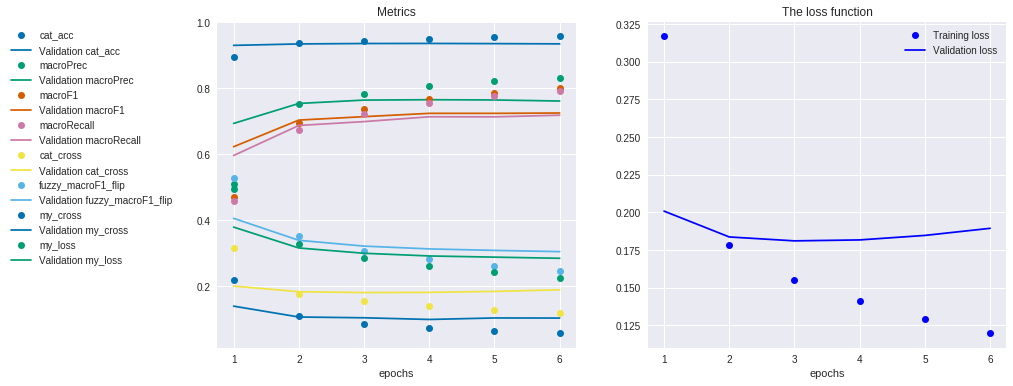

In [28]:
model1.plot(with_loss=True)

Predict classes for X's in validation data, and compute the interesting metrics using the validation y's.
(see the *BlackBox().evaluate()* method)

In [29]:
model1.evaluate(X_val, y_val)

,GlobalAvg
cat_acc,0.934660
cat_cross,0.189407
macroF1,0.796605
macroPrec,0.832014
macroRecall,0.767818
my_loss,0.233137


#### custom loss function

In [0]:
loss, batch_size, optimizer = my_loss, 200, 'nadam'

model2 = BlackBox(tag="GlobalAvg",\
                  layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                  epochs=epochs, metrics=my_metrics)

In [18]:
model2.fit(X_train, y_train, validate_on=(X_val, y_val))
model2.save_embedd()
model2.Ksave()
model2.save_hist()

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/6
500000/500000 [==============================] - 96s 192us/step - loss: 0.3752 - cat_acc: 0.9010 - macroPrec: 0.6451 - macroF1: 0.6214 - macroRecall: 0.6255 - cat_cross: 0.3428 - fuzzy_macroF1_flip: 0.4005 - my_cross: 0.1477 - my_loss: 0.3752 - val_loss: 0.2750 - val_cat_acc: 0.9233 - val_macroPrec: 0.7291 - val_macroF1: 0.7254 - val_macroRecall: 0.7498 - val_cat_cross: 0.2891 - val_fuzzy_macroF1_flip: 0.2929 - val_my_cross: 0.1140 - val_my_loss: 0.2750
Epoch 2/6
500000/500000 [==============================] - 95s 191us/step - loss: 0.2488 - cat_acc: 0.9302 - macroPrec: 0.7547 - macroF1: 0.7521 - macroRecall: 0.7757 - cat_cross: 0.2850 - fuzzy_macroF1_flip: 0.2645 - my_cross: 0.1078 - my_loss: 0.2488 - val_loss: 0.2587 - val_cat_acc: 0.9287 - val_macroPrec: 0.7440 - val_macroF1: 0.7373 - val_macroRecall: 0.7577 - val_cat_cro

In [21]:
# loading from file, in case the model was already saved
model2.Kload()
model2.load_hist()

Ovewriting the model.
Overwriting the history.


Plot the learning history of the model. Only the train-data was used for fitting.

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


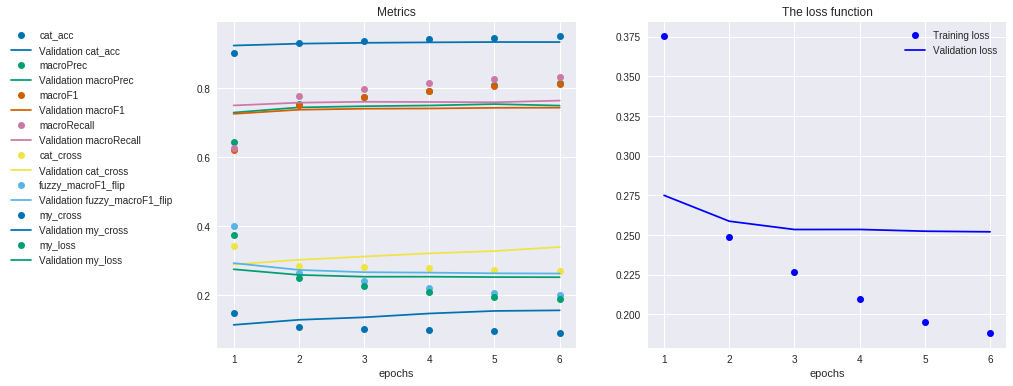

In [22]:
model2.plot(with_loss=True)

Predict classes for X's in validation data, and compute the interesting metrics using the validation y's.
(see the *BlackBox().evaluate()* method)

In [23]:
model2.evaluate(X_val, y_val)

,GlobalAvg
cat_acc,0.933350
cat_cross,0.339455
macroF1,0.807053
macroPrec,0.795369
macroRecall,0.819668
my_loss,0.197296


Metrics obtained with the two loss functions

In [31]:
eval_together = pd.concat([model1.eval_df, model2.eval_df], axis=1)
eval_together.columns = ['loss: cat. cross.', 'loss: my_loss']
eval_together.T

,cat_acc,cat_cross,macroF1,macroPrec,macroRecall,my_loss
loss: cat. cross.,0.93466,0.189407,0.796605,0.832014,0.767818,0.233137
loss: my_loss,0.93335,0.339455,0.807053,0.795369,0.819668,0.197296


### Commentary
* Looking at the validation scores: The *my_loss* function is better than *categorical crossentropy* at keeping the precision and recall equal. It actually emphasizes the recall more, so that it scores slightly better than precision. It is also faster in terms of increasing the F1 at starting epochs, which seems like an advantegous property of a loss function to be used on more complicated architectures. Still the difference in final F1 scores on validation data is not significant

* On the other hand minimizing the categorical crossentropy is better at lowering *my_loss* than minimizing the *my_loss* is at lowering crossentropy.

* Starting from about the 3rd epoch we see overfitting: the scores obtained directly on train-data are higher than on validation-data.

* Recall that our final macro-F1 on test-data reached by the SVM was 80%. Here we have not yet looked at the test-data,  but, judging by the score on the validation-data, it seems that we have reproduced the result of a shallow classifier with a 50-dimensional embedding, global averaging, and a single softmax-layer. While the model had pretty quickly gotten close to this level, the 80% seems hard to go beyond. We will yet use the knowledge gained by our grid-search and the embeddings produced by the neural networks trained above in further modelling.

---
### End